# PGGAN

## Dataset

In [1]:
# pip install gdown

In [1]:
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets.celeba import CelebA
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


transform = T.Compose(
    [
        T.Resize(64),
        T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = CelebA(
    "./datasets", download=True, transform=transform
)
loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

Files already downloaded and verified


## Generator

### Conv layer

In [2]:
import torch
import torch.nn as nn


z = torch.randn(1, 512, 1, 1)

In [3]:
layer_1_conv_1 = nn.ConvTranspose2d(512, 512, 4, 1, 0)
layer_1_conv_1(z).shape

torch.Size([1, 512, 4, 4])

In [4]:
layer_1_conv_2 = nn.Conv2d(512, 512, 3, 1, 1)
layer_1_conv_2(layer_1_conv_1(z)).shape

torch.Size([1, 512, 4, 4])

### Pixel Normalization

In [5]:
raw = torch.Tensor([i for i in range(12)]).view(1, -1, 2, 2)
raw

tensor([[[[ 0.,  1.],
          [ 2.,  3.]],

         [[ 4.,  5.],
          [ 6.,  7.]],

         [[ 8.,  9.],
          [10., 11.]]]])

In [6]:
raw / torch.sqrt(torch.mean(raw**2, dim=1, keepdim=True) + 1e-8)

tensor([[[[0.0000, 0.1674],
          [0.2928, 0.3884]],

         [[0.7746, 0.8372],
          [0.8783, 0.9062]],

         [[1.5492, 1.5070],
          [1.4639, 1.4241]]]])

In [7]:
import torch
import torch.nn as nn


class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x / torch.norm(x, p=2, dim=1, keepdim=True).clamp(min=self.epsilon)

### Weight Initialization

In [8]:
conv_1 = nn.ConvTranspose2d(512, 512, 4, 1, 0)

In [9]:
conv_1.bias[:10]

tensor([ 0.0053,  0.0012, -0.0079,  0.0070, -0.0030,  0.0098, -0.0079,  0.0101,
        -0.0003,  0.0065], grad_fn=<SliceBackward0>)

In [10]:
tmp_weight = next(conv_1.parameters())[0]
tmp_weight.mean(), tmp_weight.std()

(tensor(2.6957e-05, grad_fn=<MeanBackward0>),
 tensor(0.0064, grad_fn=<StdBackward0>))

In [11]:
_ = nn.init.normal_(conv_1.weight)
_ = nn.init.zeros_(conv_1.bias)

In [12]:
conv_1.bias[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [13]:
tmp_weight = next(conv_1.parameters())[0]
tmp_weight.mean(), tmp_weight.std()

(tensor(-0.0088, grad_fn=<MeanBackward0>),
 tensor(1.0055, grad_fn=<StdBackward0>))

### Equalized Learning Rate

In [14]:
z = torch.randn(1, 512, 1, 1)

In [15]:
conv_1 = nn.Conv2d(512, 512, 1, 1, 0)
bias = conv_1.bias
conv_1.bias = None

In [16]:
in_channels = 512
kernel_size = 4
scale = (2 / (in_channels * (kernel_size**2))) ** 0.5

In [19]:
original_result = (conv_1(z) * scale) + bias.view(1, bias.size(0), 1, 1)
original_result[0][:5]

tensor([[[-0.0101]],

        [[ 0.0016]],

        [[-0.0362]],

        [[-0.0351]],

        [[ 0.0174]]], grad_fn=<SliceBackward0>)

In [20]:
fixed_result = conv_1(z * scale) + bias.view(1, bias.size(0), 1, 1)
fixed_result[0][:5]

tensor([[[-0.0101]],

        [[ 0.0016]],

        [[-0.0362]],

        [[-0.0351]],

        [[ 0.0174]]], grad_fn=<SliceBackward0>)

In [21]:
class EqualizedLearningConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size**2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.size(0), 1, 1)

### Upsampling Layer

In [22]:
low = torch.Tensor([i for i in range(4)] * 3).view(1, -1, 2, 2)
low

tensor([[[[0., 1.],
          [2., 3.]],

         [[0., 1.],
          [2., 3.]],

         [[0., 1.],
          [2., 3.]]]])

In [23]:
near_pool = nn.Upsample(scale_factor=2, mode="nearest")
high = near_pool(low)
high

tensor([[[[0., 0., 1., 1.],
          [0., 0., 1., 1.],
          [2., 2., 3., 3.],
          [2., 2., 3., 3.]],

         [[0., 0., 1., 1.],
          [0., 0., 1., 1.],
          [2., 2., 3., 3.],
          [2., 2., 3., 3.]],

         [[0., 0., 1., 1.],
          [0., 0., 1., 1.],
          [2., 2., 3., 3.],
          [2., 2., 3., 3.]]]])

### Generator Block

In [24]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv_1 = EqualizedLearningConv2d(in_channel, out_channel, 3, 1, 1)
        self.pixel_norm_1 = PixelNorm()
        self.act_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv_2 = EqualizedLearningConv2d(out_channel, out_channel, 3, 1, 1)
        self.act_2 = nn.LeakyReLU(0.2, inplace=True)
        self.pixel_norm_2 = PixelNorm()

    def forward(self, x):
        x_out_1 = self.act_1(self.pixel_norm_1(self.conv_1(x)))
        x_out_2 = self.act_2(self.pixel_norm_2(self.conv_2(x_out_1)))
        return x_out_2

### FadeIn - ToRGB

In [25]:
to_rgb = EqualizedLearningConv2d(512, 3, kernel_size=1, stride=1, padding=0)

In [26]:
z.shape, to_rgb(z).shape

(torch.Size([1, 512, 1, 1]), torch.Size([1, 3, 1, 1]))

In [27]:
layer_1 = nn.Sequential(
    nn.ConvTranspose2d(512, 512, 4, 1, 0),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 512, 3, 1, 1),
    nn.LeakyReLU(0.2, inplace=True),
)
layer_1_out = layer_1(z)
layer_1_out.shape, to_rgb(layer_1_out).shape

(torch.Size([1, 512, 4, 4]), torch.Size([1, 3, 4, 4]))

In [28]:
layer_2 = GeneratorBlock(512, 512)
layer_2(layer_1_out).shape

torch.Size([1, 512, 4, 4])

### Class Generator

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.latent_normalizer = PixelNorm()
        self.up_sampler = nn.Upsample(scale_factor=2, mode="nearest")
        self.layer_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedLearningConv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm(),
        )
        self.layers = nn.ModuleList([])
        self.rgb_layers = nn.ModuleList([EqualizedLearningConv2d(512, 3, 1, 1, 0)])
        for layer_num in range(2, 6):
            # add layer
            self.layers += [GeneratorBlock(512, 512)]
            self.rgb_layers += [EqualizedLearningConv2d(512, 3, 1, 1, 0)]

        self.last_layer = nn.Tanh()

    def forward(self, z, alpha, step):
        # first layer
        normalized_z = self.latent_normalizer(z)
        layer_out = self.layer_1(normalized_z)

        # middle layers
        for layer_num in range(1, step):
            up_out = self.up_sampler(layer_out)
            layer_out = self.layers[layer_num - 1](up_out)

        # transform to rgb
        layer_out = self.rgb_layers[step - 1](layer_out)

        # fade in
        if alpha < 1.0 and step > 1:
            fade_out = self.rgb_layers[step - 2](up_out)
            layer_out = alpha * layer_out + (1 - alpha) * fade_out

        # 0~1 scaling
        final_out = self.last_layer(layer_out)
        return final_out

In [30]:
generator = Generator()

z = torch.rand(1, 512, 1, 1)  # (N, 512, 1, 1)
alpha = 0.5
step = 1

with torch.no_grad():
    # first layer
    layer_out = generator.layer_1(z)  # (N, 512, 4, 4)

    # middle layers
    for layer_num in range(1, step):  # one loop
        up_out = generator.up_sampler(layer_out)  # (N, 512, 8, 8)
        layer_out = generator.layers[layer_num - 1](up_out)  # (N, 512, 8, 8)

    # transform to rgb
    layer_out = generator.rgb_layers[step - 1](layer_out)  # (N, 3, 8, 8)

    # fade in
    if alpha < 1.0 and step > 1:
        fade_out = generator.rgb_layers[step - 2](up_out)
        layer_out = alpha * layer_out + (1 - alpha) * fade_out

    final_out = generator.last_layer(layer_out)

In [31]:
with torch.no_grad():
    for step in range(1, 6):
        out = generator(z, alpha=0.5, step=step)
        print(f"Step - {step} shape :", out.shape)

Step - 1 shape : torch.Size([1, 3, 4, 4])
Step - 2 shape : torch.Size([1, 3, 8, 8])
Step - 3 shape : torch.Size([1, 3, 16, 16])
Step - 4 shape : torch.Size([1, 3, 32, 32])
Step - 5 shape : torch.Size([1, 3, 64, 64])


## Discriminator

### Discriminator block

In [32]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv_1 = EqualizedLearningConv2d(in_channel, out_channel, 3, 1, 1)
        self.act_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv_2 = EqualizedLearningConv2d(out_channel, out_channel, 3, 1, 1)
        self.act_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x_out_1 = self.act_1(self.conv_1(x))
        x_out_2 = self.act_2(self.conv_2(x_out_1))
        return x_out_2

### Last layer

In [33]:
# last layer for discriminator
# input is 3 x 4 x 4 from generator
x = torch.randn(2, 512, 4, 4)

In [34]:
# last layer for Wasserstein distance
last_layer = nn.Sequential(
    EqualizedLearningConv2d(512, 512, 3, 1, 1),
    nn.LeakyReLU(0.2, inplace=True),
    EqualizedLearningConv2d(512, 512, 4, 1, 0),
    nn.LeakyReLU(0.2, inplace=True),
    EqualizedLearningConv2d(512, 1, 1, 1, 0),
)
out = last_layer(x).squeeze()
out.shape

torch.Size([2])

### Downsample

In [35]:
# down scale is used when step is greater than 2
# let's assume x is 8x8
x = torch.randn(2, 3, 8, 8)

In [36]:
# for fade in process use average pool to downscale
avg_pooler = nn.AvgPool2d(2, 2)
down_out = avg_pooler(x)
down_out.shape

torch.Size([2, 3, 4, 4])

### Fade in

In [37]:
# When layer is added we should fade in not to shock before layers
# let's assume we trained 4x4 image and now we added layer to train 8x8 image
x = torch.randn(2, 3, 8, 8)

In [38]:
# first, feed with new from RGB layer
new_rgb_layer = EqualizedLearningConv2d(3, 512, 1, 1, 0)
new_z = new_rgb_layer(x)
new_z.shape

torch.Size([2, 512, 8, 8])

In [39]:
# and feed to conv layer
new_conv_layer = DiscriminatorBlock(512, 512)
new_conv_out = new_conv_layer(new_z)
new_conv_out.shape

torch.Size([2, 512, 8, 8])

In [40]:
# last, downscale with avg_pool
avg_pool = nn.AvgPool2d(2, 2)
new_down_out = avg_pool(new_conv_out)
new_down_out.shape

torch.Size([2, 512, 4, 4])

In [41]:
# Now, feed with before RGB layer
# First, down scale with avg_pool
before_down_out = avg_pool(x)
before_down_out.shape

torch.Size([2, 3, 4, 4])

In [42]:
# next feed before rgb layer
before_rgb_layer = EqualizedLearningConv2d(3, 512, 1, 1, 0)
before_out = before_rgb_layer(before_down_out)
before_out.shape

torch.Size([2, 512, 4, 4])

In [43]:
# and add both out with given alpha term
alpha = 0.5
final_out = alpha * new_down_out + (1 - alpha) * (before_out)
final_out.shape

torch.Size([2, 512, 4, 4])

In [44]:
# and feed this with last layer
final_last_out = last_layer(final_out).squeeze()
final_last_out.shape

torch.Size([2])

### Minibatch stddev

In [45]:
def minibatch_stddev(x):  ## NxCxHxW -> N -> 1 -> Nx1xHxW
    batch_statistics = (
        torch.std(x, dim=0).mean().repeat(x.size(0), 1, x.size(2), x.size(3))
    )
    # we take the std for each example (across all channels, and pixels) then we repeat it
    # for a single channel and concatenate it with the image. In this way the discriminator
    # will get information about the variation in the batch/image
    return torch.cat([x, batch_statistics], dim=1)

### Class Discriminator

In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.avg_sampler = nn.AvgPool2d(2, 2)
        self.last_layer = nn.Sequential(
            EqualizedLearningConv2d(513, 512, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedLearningConv2d(512, 512, 4, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedLearningConv2d(512, 1, 1, 1, 0),
        )
        self.rgb_layers = nn.ModuleList([EqualizedLearningConv2d(3, 512, 1, 1, 0)])
        self.layers = nn.ModuleList([DiscriminatorBlock(512, 512)])
        for layer_num in range(2, 6):
            # add layer
            self.layers += [DiscriminatorBlock(512, 512)]
            self.rgb_layers += [EqualizedLearningConv2d(3, 512, 1, 1, 0)]

    def forward(self, x, alpha, step):
        # feed initial
        layer_out = self.rgb_layers[step - 1](x)

        if step > 1:
            layer_out = self.layers[step - 1](layer_out)
            layer_out = self.avg_sampler(layer_out)

        # for fade in
        if alpha < 1.0 and step > 1:
            fade_out = self.avg_sampler(x)
            fade_out = self.rgb_layers[step - 2](fade_out)
            layer_out = (1 - alpha) * fade_out + alpha * layer_out

        # middle layers
        for layer_num in range(2, step):
            layer_out = self.layers[layer_num](layer_out)
            layer_out = self.avg_sampler(layer_out)

        # calculate stddev
        stddev_out = minibatch_stddev(layer_out)
        # last layer
        final_out = self.last_layer(stddev_out)
        return final_out.squeeze()

In [70]:
discriminator = Discriminator()

x = torch.randn(2, 3, 16, 16)
alpha = 0.5
step = 3

with torch.no_grad():
    # feed initial
    layer_out = discriminator.rgb_layers[step - 1](x)  # (N, 512, 16, 16)
    if step > 1:
        layer_out = discriminator.layers[step - 1](layer_out)
        layer_out = discriminator.avg_sampler(layer_out)  # (N, 512, 8, 8)

    # for fade in
    if alpha < 1.0 and step > 1:
        fade_out = discriminator.avg_sampler(x)  # (N, 512, 8, 8)
        fade_out = discriminator.rgb_layers[step - 2](fade_out)  # (N, 512, 8, 8)
        layer_out = alpha * layer_out + (1 - alpha) * fade_out  # (N, 512, 8, 8)

    # middle layers
    for layer_num in range(2, step):
        layer_out = discriminator.layers[layer_num](layer_out)  # (N, 512, 8, 8)
        layer_out = discriminator.avg_sampler(layer_out)  # (N, 512, 4, 4)

    # calculate stddev
    stddev_out = minibatch_stddev(layer_out)  # (N, 513, 4, 4)
    # last layer
    final_out = discriminator.last_layer(stddev_out).squeeze()  #(N)

In [52]:
discriminator = Discriminator()

sizes = [4, 8, 16, 32, 64]
with torch.no_grad():
    for step in range(1, 6):
        x = torch.randn(2, 3, sizes[step-1], sizes[step-1])
        out = discriminator(x, alpha=0.5, step=step)
        print(f"Step - {step} shape :", out.shape)

Step - 1 shape : torch.Size([2])
Step - 2 shape : torch.Size([2])
Step - 3 shape : torch.Size([2])
Step - 4 shape : torch.Size([2])
Step - 5 shape : torch.Size([2])


### Test

In [53]:
sizes = [4, 8, 16, 32, 64]

generator = Generator()
discriminator = Discriminator()
with torch.no_grad():
    z = torch.rand(2, 512, 1, 1)
    for step in range(1, 6):
        print(f"Step - {step} start")
        fake = generator(z, alpha=0.5, step=step)
        print(f"Generated data shape :", fake.shape)
        fake_out = discriminator(fake, alpha=0.5, step=step)
        print(f"Discriminated data shape :", fake_out.shape)

Step - 1 start
Generated data shape : torch.Size([2, 3, 4, 4])
Discriminated data shape : torch.Size([2])
Step - 2 start
Generated data shape : torch.Size([2, 3, 8, 8])
Discriminated data shape : torch.Size([2])
Step - 3 start
Generated data shape : torch.Size([2, 3, 16, 16])
Discriminated data shape : torch.Size([2])
Step - 4 start
Generated data shape : torch.Size([2, 3, 32, 32])
Discriminated data shape : torch.Size([2])
Step - 5 start
Generated data shape : torch.Size([2, 3, 64, 64])
Discriminated data shape : torch.Size([2])


## Train

### Device Setting

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [87]:
_ = discriminator.to(device)
_ = generator.to(device)

### Logger

In [88]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logger
writer = SummaryWriter()

### Optimizer

In [89]:
import torch.optim as optim

# optimizer
discriminator_opt = optim.Adam(discriminator.parameters(), lr= 0.001, betas=(0, 0.99))
generator_opt = optim.Adam(generator.parameters(), lr= 0.001, betas=(0, 0.99))

### Gradient penalty

In [115]:
def compute_gradient_penalty(discriminator, real_data, fake_data, alpha, step):
    device = real_data.device
    beta = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    beta = beta.expand(real_data.size())

    interpolates = beta * real_data + ((1 - beta) * fake_data)
    interpolates = interpolates.to(device)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = discriminator(interpolates, alpha, step)
    grad_outputs = torch.ones(disc_interpolates.size(), requires_grad=False).to(device)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Code

In [ ]:
from tqdm import tqdm


# for meta
n_epochs = 1
n_progressive_epochs = 5
lambda_gp = 10
drift_eps = 0.001
image_sizes = [4, 8, 16, 32, 64]
batch_sizes = [64, 64, 64, 64, 32]

# for visualization
iteration = 0
fixed_z = torch.randn((64, 512, 1, 1)).to(device)

# for iteration history
G_loss_history = []
D_loss_history = []

# train code
for progressive_epoch in range(1, n_progressive_epochs + 1):
    alpha = 0.0
    size = image_sizes[progressive_epoch - 1]
    batch_size = batch_sizes[progressive_epoch - 1]
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    for epoch in range(n_epochs):
        epoch_G_loss = 0.0
        epoch_D_loss = 0.0

        for step, batch in enumerate(
            tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")
        ):
            generator.train()
            discriminator.train()

            x = batch[0]
            x = T.Resize((size, size))(x)
            x = x.to(device)
            batch_size = x.size(0)
            #
            # 1. get discriminator loss and drift from real data 
            #
            discriminator_opt.zero_grad()
            real_D_score = discriminator(x, alpha, progressive_epoch)
            real_D_loss = real_D_score.mean()
            real_D_loss_drift = (real_D_score**2).mean()
            #
            # 2. get discriminator loss from fake data
            #
            z = torch.randn((batch_size, 512, 1, 1)).to(device)
            fake_data = generator(z, alpha, progressive_epoch)
            fake_D_score = discriminator(fake_data, alpha, progressive_epoch)
            fake_D_loss = fake_D_score.mean()
            #
            # 3. get penalty
            #
            gradient_penalty = compute_gradient_penalty(
                discriminator, x, fake_data, alpha, progressive_epoch
            )
            #
            # 4. get discriminator loss and update discriminator
            #
            D_loss = (
                -real_D_loss
                + fake_D_loss
                + lambda_gp * gradient_penalty
                + drift_eps * real_D_loss_drift
            )
            D_loss.backward()
            discriminator_opt.step()

            #
            # 5. get generator loss and update generator, n_critic is 1.
            #

            generator_opt.zero_grad()
            z = torch.randn((batch_size, 512, 1, 1)).to(device)
            generated_data = generator(z, alpha, progressive_epoch)
            generate_D_score = discriminator(generated_data, alpha, progressive_epoch)
            G_loss = -generate_D_score.mean()
            G_loss.backward()
            generator_opt.step()

            #
            # 6. update alpha
            #
            alpha +=  1/ (len(loader) * n_epochs)
            alpha = min(alpha, 1)

            # logging
            D_loss_history += [D_loss.item()]
            G_loss_history += [G_loss.item()]

            epoch_D_loss += D_loss.item() * len(x) / len(loader.dataset)
            epoch_G_loss += G_loss.item() * len(x) / len(loader.dataset)

            writer.add_scalar("Loss/discriminator", D_loss, iteration)
            writer.add_scalar("Loss/generator", G_loss, iteration)

            # iteration checkpoint
            if iteration % 2000 == 0:
                # visualization
                with torch.no_grad():
                    generated_x = generator(fixed_z, 1.0, progressive_epoch)
                    generated_x = generated_x.detach().cpu()
                    generated_x_grid = make_grid(generated_x, nrow=8).numpy()
                    generated_x_grid = (generated_x_grid * 0.5) + 0.5
                    generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
                    plt.imsave(f"pggan-step-{iteration}.png", generated_x_grid)
            iteration += 1

        # last visualization
        with torch.no_grad():
            generated_x = generator(fixed_z, 1.0, progressive_epoch)
            generated_x = generated_x.detach().cpu()
            generated_x_grid = make_grid(generated_x, nrow=8).numpy()
            generated_x_grid = (generated_x_grid * 0.5) + 0.5
            generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
            plt.imsave(f"pggan-step-{iteration}.png", generated_x_grid)
        log_string = f"Loss at epoch {epoch + 1} - D_loss : {epoch_D_loss:.4f}, G_loss : {epoch_G_loss:.4f}"
        print(log_string)

Epoch 1/1: 100%|██████████| 2543/2543 [04:14<00:00,  9.99it/s]


Loss at epoch 1 - D_loss : 0.1584, G_loss : -0.0300


Epoch 1/1: 100%|██████████| 2543/2543 [05:06<00:00,  8.29it/s]


Loss at epoch 1 - D_loss : -0.1635, G_loss : 0.1715


Epoch 1/1: 100%|██████████| 2543/2543 [11:29<00:00,  3.69it/s]


Loss at epoch 1 - D_loss : -0.5355, G_loss : 0.8822


Epoch 1/1: 100%|██████████| 2543/2543 [25:38<00:00,  1.65it/s]


Loss at epoch 1 - D_loss : -0.7152, G_loss : 1.5441


Epoch 1/1: 100%|██████████| 5086/5086 [1:27:46<00:00,  1.04s/it]


Loss at epoch 1 - D_loss : -0.7717, G_loss : 2.6673


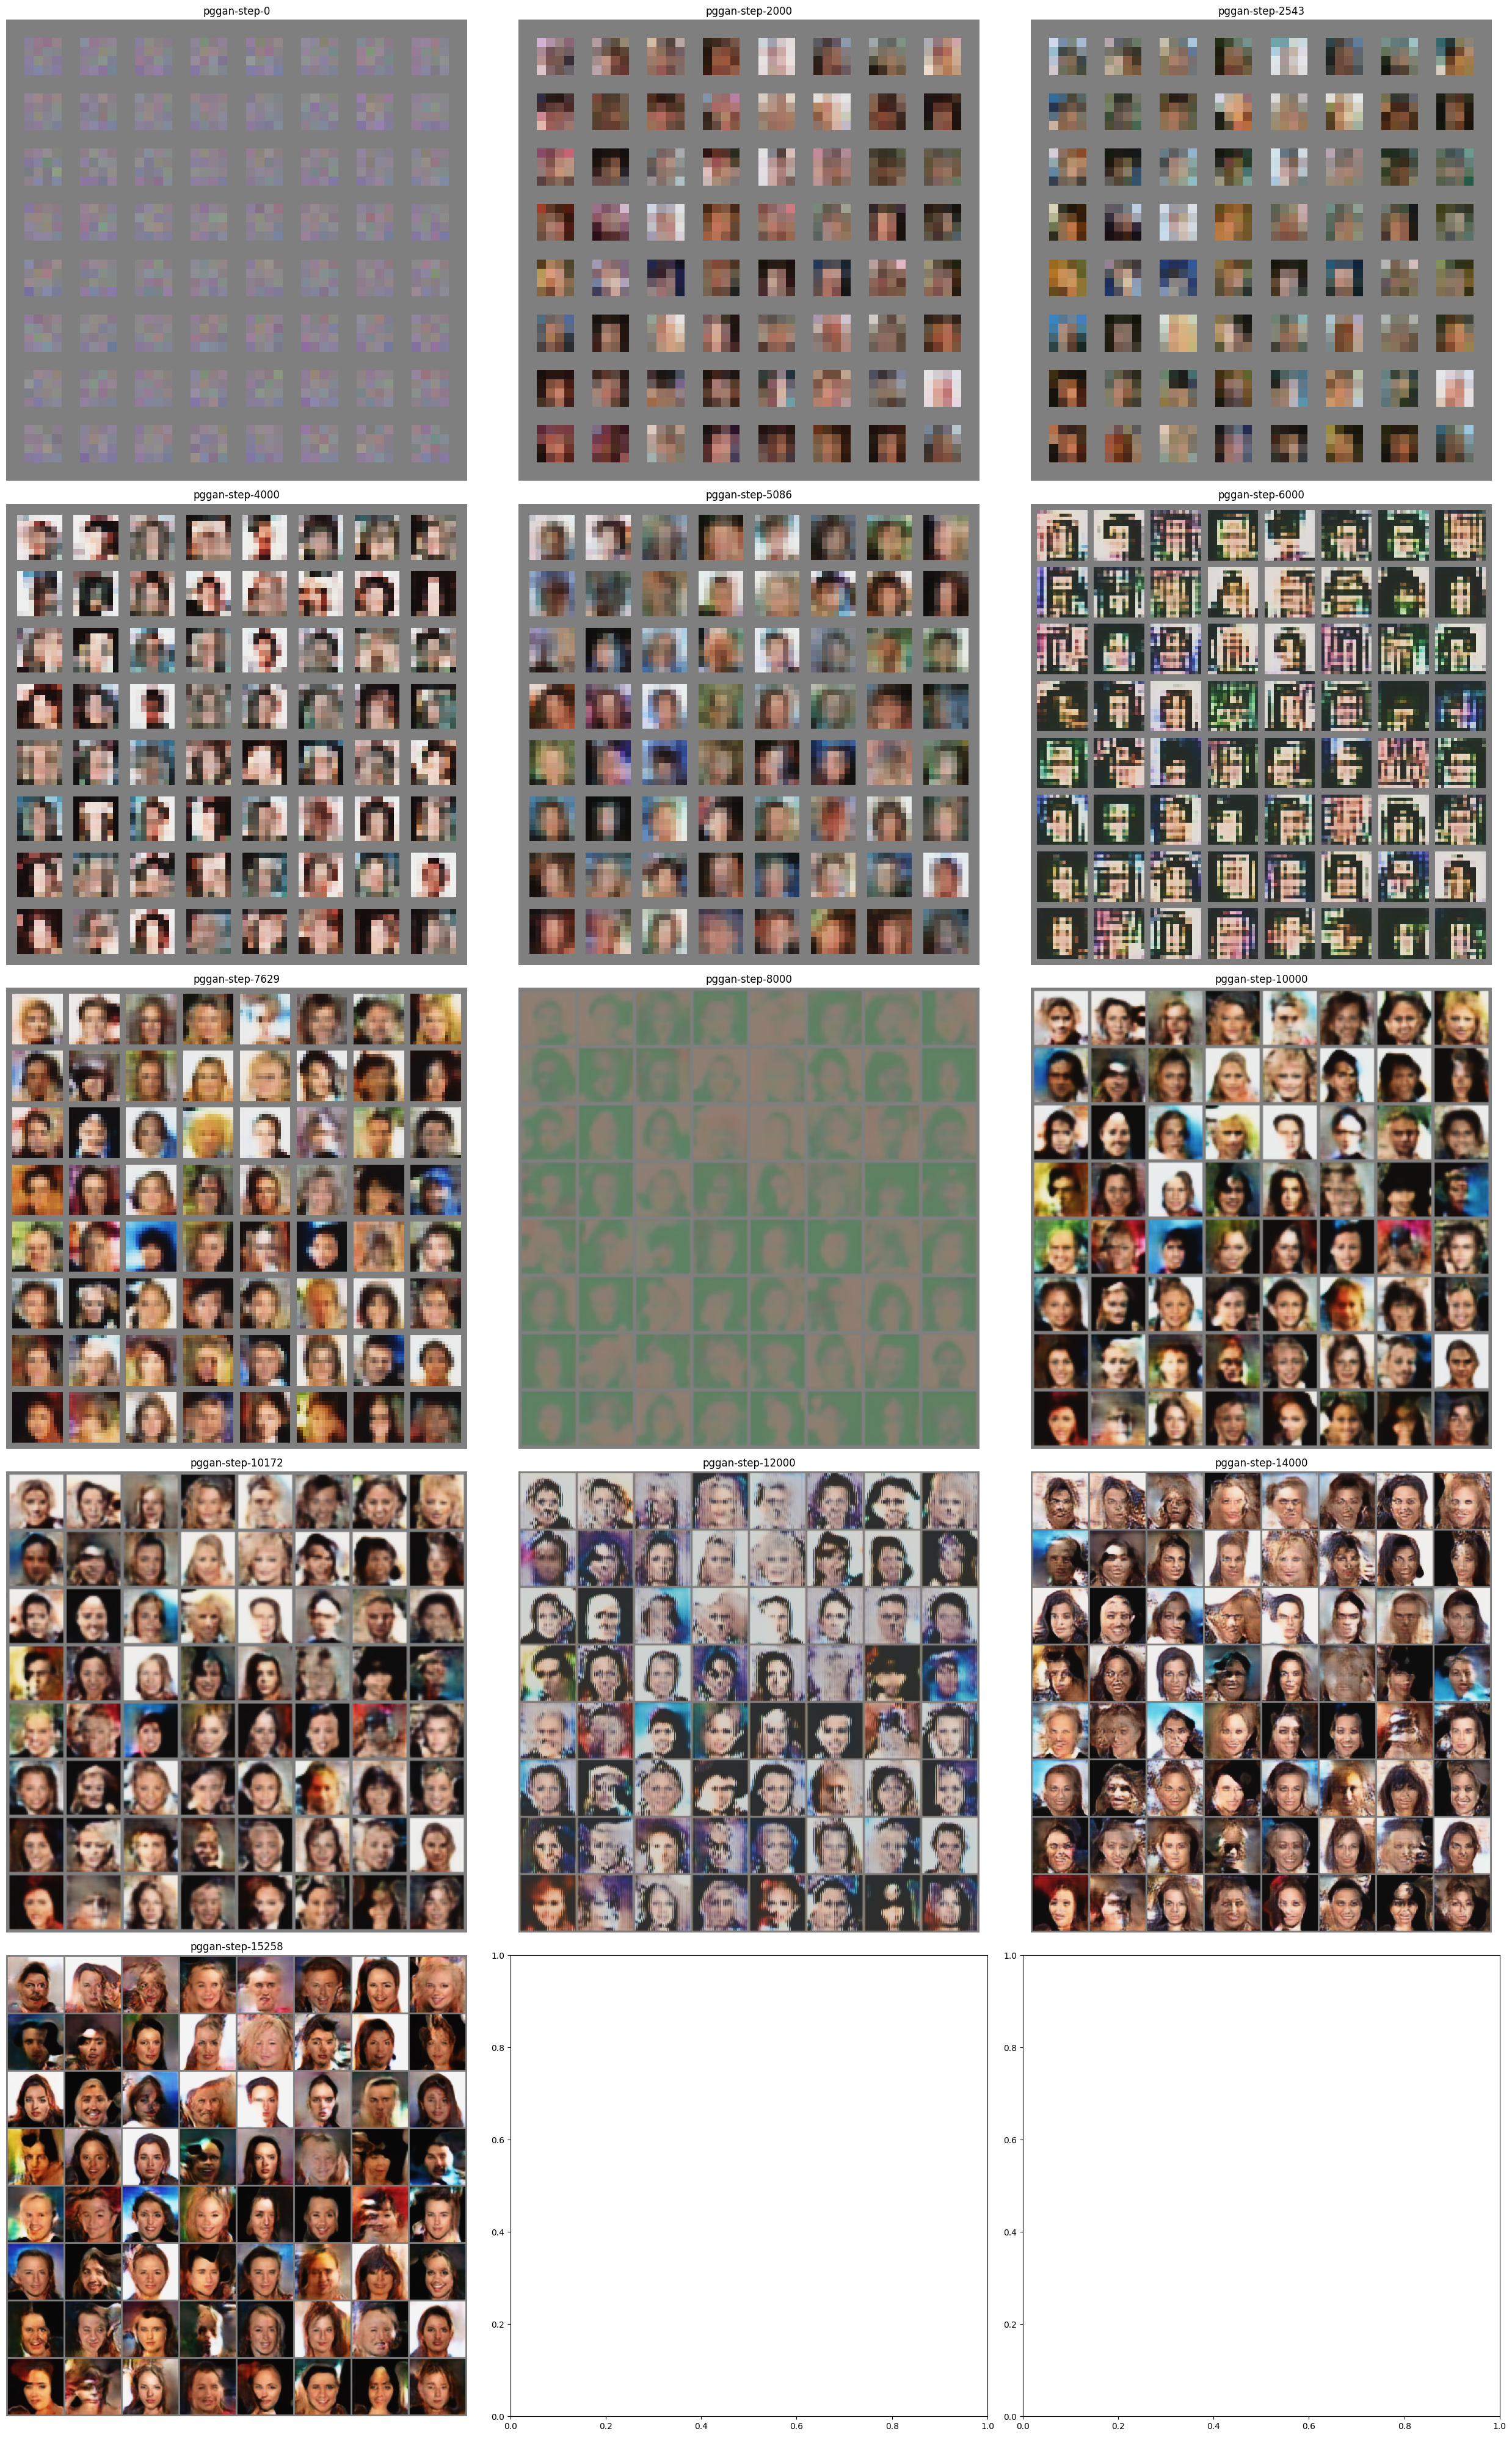

In [ ]:
import os

img_list = list(sorted(filter(lambda x: x.startswith("pggan-step"), os.listdir("."))))
step_filename = {}
for fname in filter(lambda x: x.startswith("pggan-step"), os.listdir(".")):
    key = int(fname.replace("pggan-step-", "").replace(".png", ""))
    step_filename[key] = fname

nrows = (len(img_list) // 3) + 1

fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(5 * nrows, 40))
for idx, key in enumerate(sorted(step_filename)):
    fname = step_filename[key]
    array = plt.imread(fname)
    axes[idx // 3, idx % 3].imshow(array)
    axes[idx // 3, idx % 3].axis("off")
    axes[idx // 3, idx % 3].set_title(fname.replace(".png", ""))

plt.tight_layout()

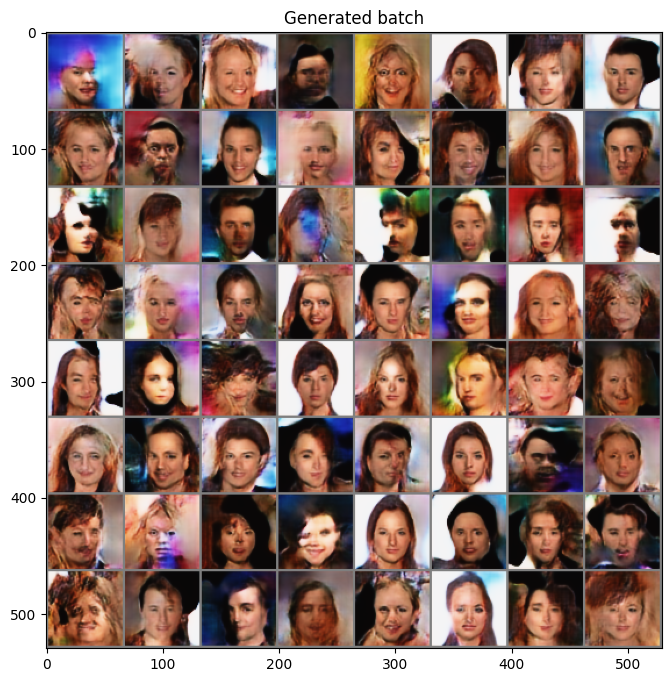

In [ ]:
generator.eval()
with torch.no_grad():    
    random_z = torch.randn((64, 512, 1, 1)).to(device)
    generated_x = generator(random_z, alpha=1, step=5)

generated_x_grid = make_grid(generated_x, nrow=8).cpu().numpy()
# make data range to 0~1
generated_x_grid = (generated_x_grid * 0.5) + 0.5
plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(np.transpose(generated_x_grid, (1, 2, 0)))